<a href="https://colab.research.google.com/github/crialejo24/YOPAL/blob/main/YOPAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.setrecursionlimit(15000)

In [ ]:
!pip install keras==2.15.0
!pip install tensorflow==2.15.0

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
import ee
import geemap
import pandas as pd
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow
import os

In [ ]:
!pip install rasterio
import rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.7 MB/s eta 0:00:00


In [ ]:
# Drive
drive.mount('/content/drive')

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='cristian-ia')

Mounted at /content/drive


In [ ]:
def look_SAR_roi(start_date, end_date, lat1, lat2, long1, long2, pol = 'VH', dir = 'DESCENDING'):
  ROI = ee.Geometry.Rectangle(long1, lat2, long2, lat1)
  sar = (ee.ImageCollection('COPERNICUS/S1_GRD').
        filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol)).
        filterBounds(ROI).filterDate(start_date, end_date).
        filter(ee.Filter.eq('instrumentMode', 'IW')).
        filter(ee.Filter.eq('orbitProperties_pass', dir)).
        #filter(ee.Filter.eq('resolution_meters', 10)).
        select(pol))
  print('Images found: ', sar.size().getInfo())
  if sar.size().getInfo() == 0:
    return None
  else:
    return sar.first().clip(ROI)

def mask_s2_clouds(image):
  #https://philippgaertner.github.io/2020/08/percent-cloud-cover/
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )
  return image.updateMask(mask).divide(10000)

def look_opt(LON1, LAT1, LON2, LAT2, date1, date2, clouds):
  ROI = ee.Geometry.Rectangle(LON1, LAT1, LON2, LAT2)

  dataset_s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate(date1, date2)
              .filterBounds(ROI)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', clouds))
              .map(mask_s2_clouds))

  bandas = ['B4', 'B3', 'B2', 'B8'] #B4:Red, B3:Green, B2:Blue, B8:NIR #https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/sentinel-2a/
  visualization_s2 = {'min': 0,
                    'max': 0.3,
                    'bands': bandas[0:3]}
  imagen = dataset_s2.select(bandas).median().clip(ROI)
  imagen = imagen.visualize(**visualization_s2)

  imagen_median = dataset_s2.median().clip(ROI)
  ndvi = imagen_median.normalizedDifference(['B8', 'B4']).rename('NDVI')
  ndvi = ndvi.visualize(min = -1, max = 1)

  return imagen, ndvi

def lee_filter(img, window_size=5):
    """
    Aplica el filtro Lee para reducir speckle.
    :param img: Imagen de entrada (escala de grises).
    :param window_size: Tamaño de la ventana (impar, ej. 3, 5, 7).
    :return: Imagen filtrada.
    """
    # Asegurar que la imagen es float32 para cálculos
    img_float = img.astype(np.float32)

    # Paso 1: Calcular la media local
    mean = cv2.blur(img_float, (window_size, window_size))

    # Paso 2: Calcular la varianza local
    mean_sq = cv2.blur(img_float**2, (window_size, window_size))
    variance = mean_sq - mean**2

    # Paso 3: Aplicar fórmula del filtro Lee
    # (Evitar división por cero con un pequeño epsilon)
    img_filtered = mean + (variance * (img_float - mean)) / (variance + 1e-6)

    # Recortar valores y convertir a uint8
    return np.clip(img_filtered, 0, 255).astype(np.uint8)

def classify_water(image_path, threshold=100):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None, None
    ret, water_mask = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    water_mask = water_mask // 255
    classification_img = np.full((img.shape[0], img.shape[1], 3), [0, 0, 255], dtype=np.uint8) # Red in BGR

    # Set water pixels to blue
    classification_img[water_mask == 1] = [255, 0, 0] # Blue in BGR

    return water_mask, classification_img


ROI DE INTERES



In [ ]:
zone = 'yopal'

folder = zone + '/'
dirname = os.path.join(os.getcwd(), '/content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/'+ folder)

if not os.path.exists(dirname):
  os.makedirs(dirname)

if zone == 'cravo':
    # Río Cravo
    lat1, long1, lat2, long2 = 5.3644, -72.40731, 5.34637, -72.36680

elif zone == 'yopal':
    # Área urbana de Yopal
    lat1, long1, lat2, long2 = 5.365804603562254, -72.41685796034183,  5.3116807463918505, -72.35932748826205


In [ ]:
ROI = ee.Geometry.Rectangle(long1, lat2, long2, lat1)
visROI = {'color' : 'red'}
#cravo(agua)
#ndvi(las dos)
sar = look_SAR_roi('2022-01-01', '2025-05-25', lat1, long1, lat2, long2)
Map = geemap.Map()
Map.centerObject(ROI, 12)
Map.addLayer(ROI, visROI, 'ROI')
Map


Images found:  38236


Map(center=[5.338742945756065, -72.38809272430416], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:

years = ['2021','2022', '2023', '2024', '2025']
months = ['05']

for year in years:
  print('Year: ', year)
  for month in months:
    print('Month: ', month)

    first_day = '01'
    if month == '02':
      last_day = '28'
    else:
      last_day = '30'

    start_date = year + '-' + month + '-' + first_day
    end_date = year + '-' + month + '-' + last_day

    # VH
    sarVH = look_SAR_roi(start_date, end_date, lat1, lat2, long1, long2, pol = 'VH', dir = 'DESCENDING') #Rubén
    #sarVH = BuscarSAR(start_date, end_date, lat1, long1, lat2, long2, pol = 'VH', dir = 'ASCENDING') #Jean
    if sarVH is not None:
      sarVH_vis = sarVH.visualize(**{'min' : -25, 'max' : 5})
      info = sarVH_vis.getInfo()
      print(info['bands'][0]['dimensions']) #Buscar tamaño con función Rubén
      # Export
      export_path = filename = dirname + year + '-' + month + '.tif'
      geemap.ee_export_image(sarVH_vis, export_path, scale = 10, file_per_band=False)






Year:  2021
Month:  05
Images found:  2
[642, 602]
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/yopal/2021-05.tif
Year:  2022
Month:  05
Images found:  2
[641, 602]
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/yopal/2022-05.tif
Year:  2023
Month:  05
Images found:  3
[642, 602]
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/yopal/2023-05.tif
Year:  2024
Month:  05
Images found:  2
[642, 603]
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/yopal/2024-05.tif
Year:  2025
Month:  05
Images found:  5
[642, 602]
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/yopal/2025-05.tif


In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

# Configuración de paths
basepath = '/content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/'
input_folder = basepath + 'yopal/'  # Carpeta con imágenes de entrada
output_folder = basepath + 'processed/'  # Carpeta para guardar resultados

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Cargar modelo
autoencoder = load_model(basepath + 'model.h5')

# Tamaño del bloque (ajustar según tu autoencoder)
block_size = 512

# Función para procesar una imagen individual
def process_image(img_path, output_path):
    # Cargar imagen
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error al cargar {img_path}")
        return

    h, w = img.shape

    # Lista para almacenar bloques
    blocks = []

    # Extraer bloques sin solapamiento
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            y_end = min(y + block_size, h)
            x_end = min(x + block_size, w)
            block = img[y:y_end, x:x_end]

            # Rellenar con ceros si es necesario
            if block.shape != (block_size, block_size):
                padded_block = np.zeros((block_size, block_size), dtype=np.float32)
                padded_block[:block.shape[0], :block.shape[1]] = block
                block = padded_block

            blocks.append(block)

    # Preprocesar y predecir cada bloque
    processed_blocks = []
    for block in blocks:
        # Normalizar y añadir dimensión de canal
        block_norm = block.astype('float32') / 255.0
        block_norm = np.expand_dims(block_norm, axis=-1)

        # Predecir
        predicted = autoencoder.predict(np.expand_dims(block_norm, axis=0))[0]
        predicted = (predicted * 255.0).astype(np.uint8)
        processed_blocks.append(predicted[:, :, 0])

    # Reconstruir imagen
    n_blocks_y = (h + block_size - 1) // block_size
    n_blocks_x = (w + block_size - 1) // block_size

    output_img = np.zeros((h, w), dtype=np.uint8)

    block_idx = 0
    for i in range(n_blocks_y):
        for j in range(n_blocks_x):
            y_start = i * block_size
            x_start = j * block_size
            y_end = min(y_start + block_size, h)
            x_end = min(x_start + block_size, w)

            block_h = y_end - y_start
            block_w = x_end - x_start

            output_img[y_start:y_end, x_start:x_end] = processed_blocks[block_idx][:block_h, :block_w]
            block_idx += 1

    # Guardar imagen procesada
    cv2.imwrite(output_path, output_img)
    print(f"Imagen procesada guardada en: {output_path}")

# Procesar todas las imágenes en la carpeta de entrada
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        print(f"\nProcesando: {filename}")
        process_image(input_path, output_path)

print("\nProcesamiento completo!")


Procesando: 2021-05.tif
1/1 [==============================] - 0s 257ms/step
Imagen procesada guardada en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/processed/2021-05.tif

Procesando: 2024-05.tif
1/1 [==============================] - 0s 246ms/step
Imagen procesada guardada en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/processed/2024-05.tif

Procesando: 2022-05.tif
1/1 [==============================] - 0s 397ms/step
Imagen procesada guardada en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/processed/2022-05.tif

Procesando: 2023-05.tif
1/1 [==============================] - 0s 352ms/step
Imagen procesada guardada en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/processed/2023-05.tif

Procesando: 2025-05.tif
1/1 [==============================] - 0s 206ms/step
Imagen procesada guardada en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/processed/2025-05.tif



Comparing 5 pairs of images:


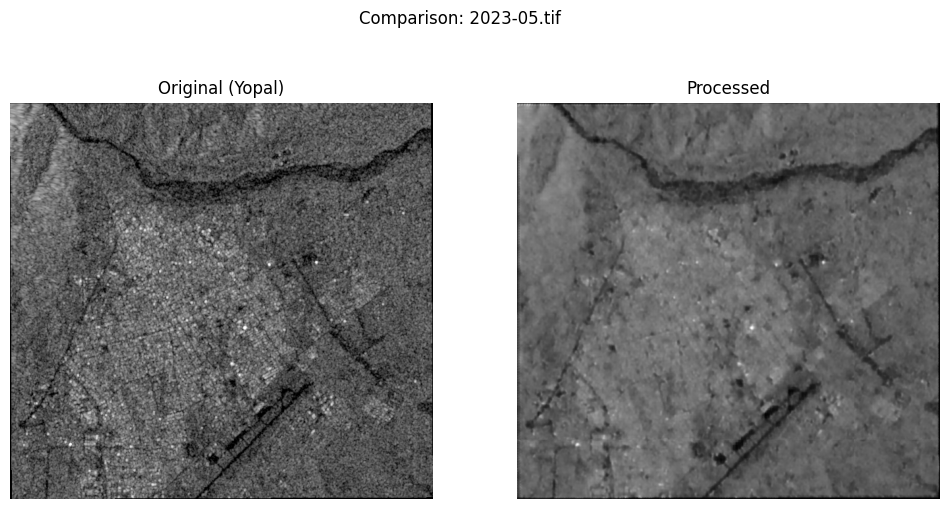

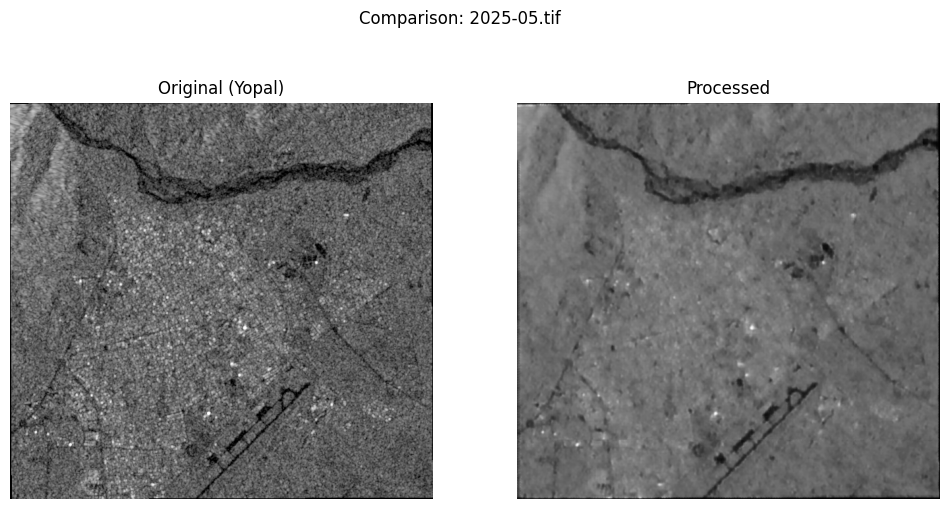

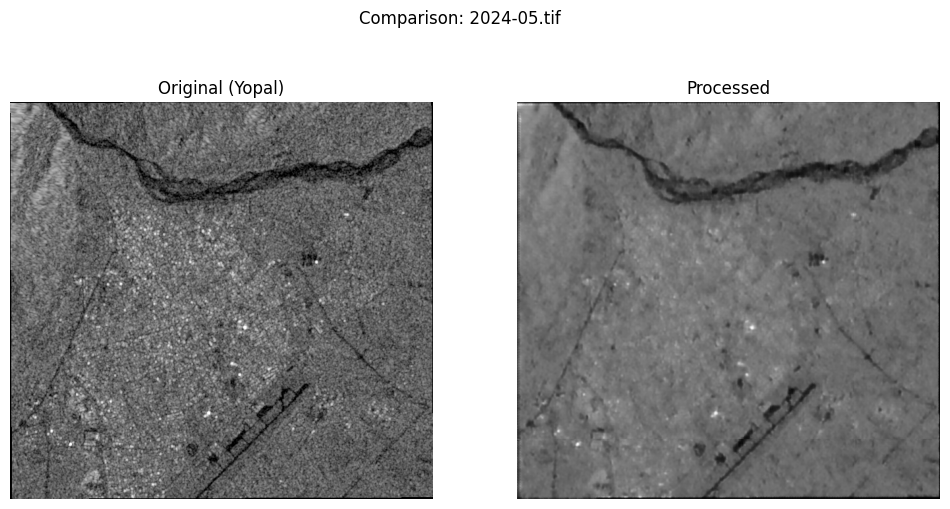

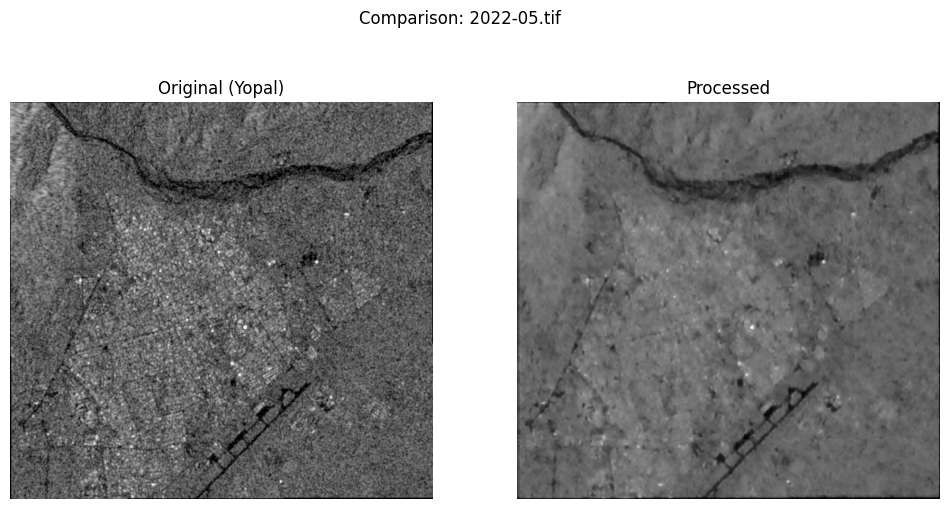

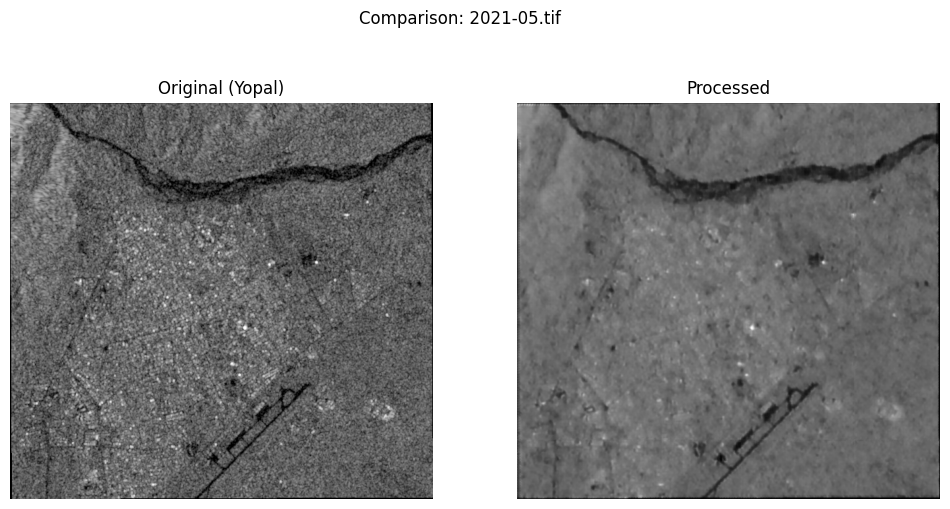

Comparison complete!


In [ ]:
# prompt: i want compare yopal with processed

import matplotlib.pyplot as plt

# Function to compare two images side-by-side
def compare_images(img1_path, img2_path, title1='Original', title2='Processed'):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None:
        print(f"Error loading image: {img1_path}")
        return
    if img2 is None:
        print(f"Error loading image: {img2_path}")
        return

    # Resize the processed image to match the original if dimensions differ
    if img1.shape != img2.shape:
      print(f"Warning: Image dimensions do not match. Resizing processed image.")
      img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(title2)
    axes[1].axis('off')

    plt.suptitle(f"Comparison: {os.path.basename(img1_path)}")
    plt.show()

# List files in both directories
yopal_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.tif', '.tiff'))]) # Assuming you processed .tif
processed_files = sorted([f for f in os.listdir(output_folder) if f.lower().endswith(('.tif', '.tiff'))]) # Assuming you saved as .tif

# Find files with the same base name to compare
comparable_files = list(set(yopal_files) & set(processed_files))

if not comparable_files:
    print("No corresponding files found in 'yopal' and 'processed' folders with the same name.")
else:
    print(f"\nComparing {len(comparable_files)} pairs of images:")
    for filename in comparable_files:
        yopal_path = os.path.join(input_folder, filename)
        processed_path = os.path.join(output_folder, filename)

        compare_images(yopal_path, processed_path, title1='Original (Yopal)', title2='Processed')

print("Comparison complete!")


In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

# Configuración de paths
basepath = '/content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/'
input_folder = basepath + 'yopal/'  # Carpeta con imágenes de entrada
output_folder = basepath + 'water_classification/'  # Carpeta principal para resultados

# Crear subcarpetas para organizar los resultados
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, 'masks'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'visualizations'), exist_ok=True)

# Umbral para clasificación de agua (ajustar según necesidad)
classification_threshold = 5

def classify_water(image_path, threshold):
    """Clasifica agua en una imagen y devuelve la máscara y visualización"""
    # Cargar imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error al cargar {image_path}")
        return None, None

    # Crear máscara binaria (agua = 1, no agua = 0)
    water_mask = (img <= threshold).astype(np.uint8) * 255

    # Crear visualización (azul para agua, rojo para no agua)
    visualization = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    visualization[water_mask == 255] = [255, 0, 0]  # Agua en azul
    visualization[water_mask == 0] = [0, 0, 255]   # No agua en rojo

    return water_mask, visualization

# Procesar todas las imágenes en la carpeta de entrada
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
        input_path = os.path.join(input_folder, filename)

        print(f"\nProcesando: {filename}")

        # Clasificar agua
        water_mask, visualization = classify_water(input_path, classification_threshold)

        if water_mask is not None and visualization is not None:
            # Guardar resultados
            base_name = os.path.splitext(filename)[0]

            # Guardar máscara binaria
            mask_path = os.path.join(output_folder, 'masks', f'water_mask_{base_name}.png')
            cv2.imwrite(mask_path, water_mask)

            # Guardar visualización
            vis_path = os.path.join(output_folder, 'visualizations', f'water_vis_{base_name}.png')
            cv2.imwrite(vis_path, visualization)

            # Mostrar estadísticas
            water_pixel_count = np.sum(water_mask == 255)
            total_pixels = water_mask.size
            water_percentage = (water_pixel_count / total_pixels) * 100

            print(f"  - Total pixels: {total_pixels}")
            print(f"  - Water pixels: {water_pixel_count}")
            print(f"  - Percentage of water: {water_percentage:.2f}%")
            print(f"  - Resultados guardados en: {mask_path} y {vis_path}")

print("\nProcesamiento completo! Todas las imágenes han sido clasificadas.")


Procesando: 2021-05.tif
  - Total pixels: 386484
  - Water pixels: 5041
  - Percentage of water: 1.30%
  - Resultados guardados en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/water_classification/masks/water_mask_2021-05.png y /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/water_classification/visualizations/water_vis_2021-05.png

Procesando: 2024-05.tif
  - Total pixels: 387126
  - Water pixels: 5628
  - Percentage of water: 1.45%
  - Resultados guardados en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/water_classification/masks/water_mask_2024-05.png y /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/water_classification/visualizations/water_vis_2024-05.png

Procesando: 2022-05.tif
  - Total pixels: 385882
  - Water pixels: 4678
  - Percentage of water: 1.21%
  - Resultados guardados en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/water_classification/masks/wate

Redimensionando water_mask_2022-05.png de (602, 641) a (602, 642)
Redimensionando water_mask_2024-05.png de (603, 642) a (602, 642)


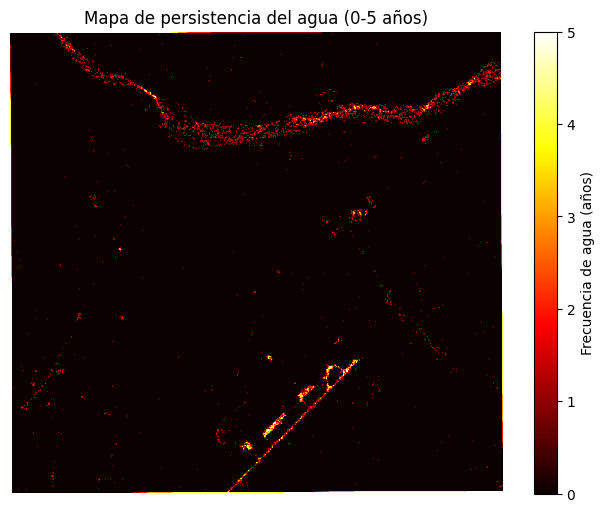


Mapa de calor generado y guardado en: /content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/water_classification/masks/water_change_heatmap.png


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carpeta con máscaras
masks_folder = '/content/drive/MyDrive/vision-ia/Teledetección con GEE/analisis yopal/water_classification/masks'

# Listar las máscaras
mask_files = sorted([f for f in os.listdir(masks_folder) if f.startswith('water_mask_') and f.endswith('.png')])

if not mask_files:
    print("No se encontraron máscaras de agua.")
else:
    # Cargar la primera máscara como referencia de tamaño
    ref_path = os.path.join(masks_folder, mask_files[0])
    ref_mask = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
    ref_shape = ref_mask.shape
    accumulation = np.zeros(ref_shape, dtype=np.uint8)

    # Procesar todas las máscaras
    for mask_file in mask_files:
        mask_path = os.path.join(masks_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is not None:
            # Redimensionar si el tamaño no coincide
            if mask.shape != ref_shape:
                print(f"Redimensionando {mask_file} de {mask.shape} a {ref_shape}")
                mask = cv2.resize(mask, (ref_shape[1], ref_shape[0]), interpolation=cv2.INTER_NEAREST)

            binary_mask = (mask == 255).astype(np.uint8)
            accumulation += binary_mask
        else:
            print(f"No se pudo leer {mask_file}")

    # Mostrar mapa de calor
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(accumulation, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Frecuencia de agua (años)')
    plt.title('Mapa de persistencia del agua (0-5 años)')
    plt.axis('off')

    # Guardar resultado
    heatmap_path = os.path.join(masks_folder, 'water_change_heatmap.png')
    plt.savefig(heatmap_path, bbox_inches='tight', dpi=300)
    plt.show()

    print(f"\nMapa de calor generado y guardado en: {heatmap_path}")
